In [1]:
%matplotlib notebook
from IPython.display import Image

In [2]:
import h5py
import torch
import numpy as np

from sklearn import decomposition

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import matplotlib.animation as animation

In [3]:
MODEL_PATH = '/u/xl/tjlane/cryoem/dynanet/particle_simulations/ortho/toys/semicirc_sigma2/results/'
#MODEL_PATH = '/u/xl/tjlane/opt/orthonet/scripts/results'
DATA_PATH  = '/u/xl/tjlane/opt/orthonet/toymodels'

In [4]:
# load some data
f = h5py.File(DATA_PATH + '/bot_quarter_circle_sigma2.00.h5','r')
origin = np.array(f['data'])
r      = np.array(f['r'])
theta  = np.array(f['theta'])
print(f.keys())
f.close()

print(origin.shape, r.shape, theta.shape)
model = torch.load(MODEL_PATH + '/model.pt')

ot = torch.tensor(origin.astype(np.float32))
latent = model.encode(ot)
recon  = model(ot)

# deals with VAE case where I also saved logvar, use only mu here
if type(latent) == tuple:
    latent = latent[0].detach().numpy()
    recon = recon[0].detach().numpy()
else:
    latent = latent.detach().numpy()
    recon = recon.detach().numpy()
    
print(latent.shape)
print(recon.shape)

<KeysViewHDF5 ['I', 'data', 'params', 'r', 'theta']>
(25000, 33, 33) (25000,) (25000,)
(25000, 10)
(25000, 33, 33)


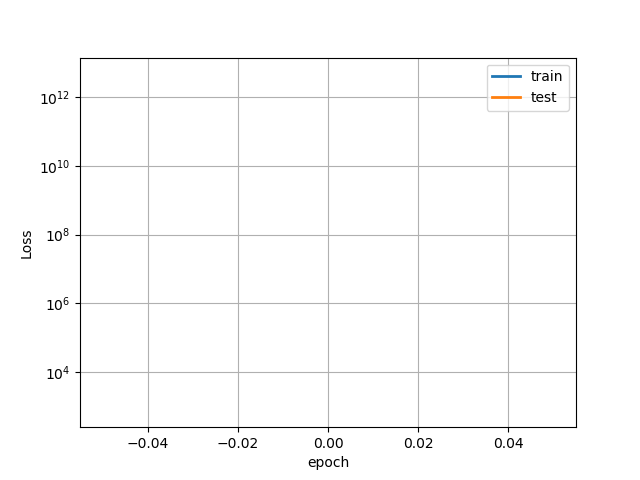

In [5]:
Image(filename=MODEL_PATH + '/loss_curves.png')

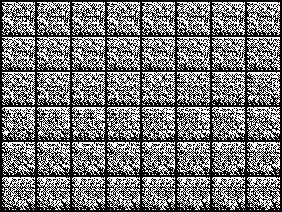

In [6]:
Image(filename=MODEL_PATH + '/z0.png')

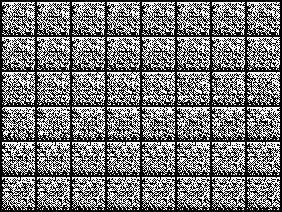

In [7]:
Image(filename=MODEL_PATH + '/z1.png')

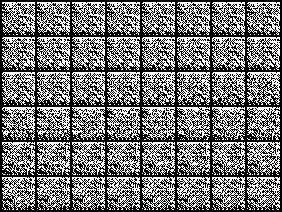

In [8]:
Image(filename=MODEL_PATH + '/z2.png')

## Analysis of Latent Space

<IPython.core.display.Javascript object>


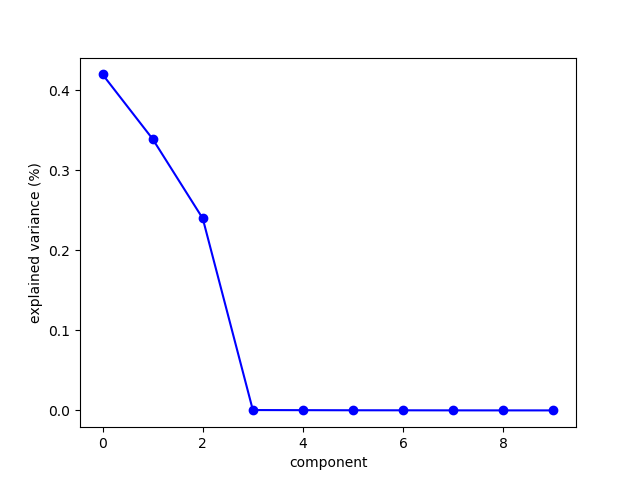

In [40]:
n_components = latent.shape[1]

pca = decomposition.PCA(n_components=n_components)
pca.fit(latent)

plt.figure()
plt.plot(pca.explained_variance_ratio_, 'bo')
plt.plot(pca.explained_variance_ratio_, 'b-')
plt.xlabel('component')
plt.ylabel('explained variance (%)')
plt.show()

<IPython.core.display.Javascript object>


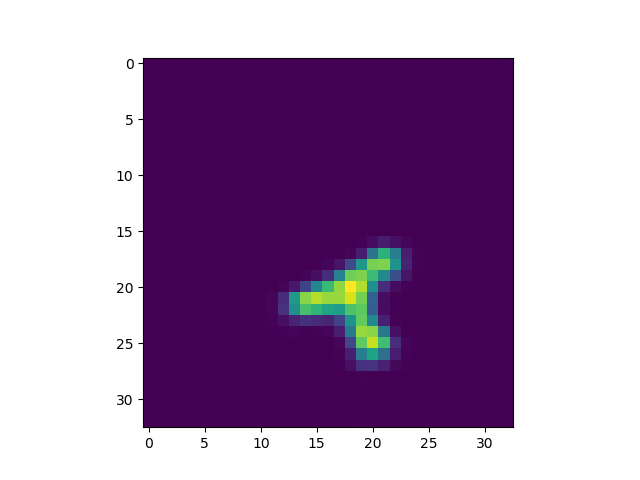

In [41]:
# trace out the PC space

samples = 100
lim = 5 # 2
res = 0.1 # 0.05
fps = 60

basis = 'pcs'
#basis = 'latent'

c = 0
    
fig = plt.figure()
ims = []

limit_list = [(l,l+res) for l in np.arange(-lim,lim,res)]

for limits in limit_list:

    s = np.linspace(limits[0], limits[1], num=samples)
    if basis == 'pcs':
        z = pca.components_[c]
    elif basis == 'latent':
        z = np.eye(n_components)[c]

    x = torch.tensor(np.outer(s, z).astype(np.float32))
    rx = model.decode(x).detach().numpy().reshape(-1, 33, 33)

    ims.append( [plt.imshow(rx.mean(0), animated=True)] )

ani = animation.ArtistAnimation(fig, ims, interval=fps, blit=True,
                                repeat_delay=0)
#ani.save(MODEL_PATH + '/%s_%d_movie.mp4' % (basis, c), 
#         fps=fps, extra_args=['-vcodec', 'libx264'])
plt.show()

In [44]:
latent_in_pc = pca.transform(latent)
print(latent_in_pc.shape)

fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(121, projection='3d')

ax.scatter(latent_in_pc[:,0],
           latent_in_pc[:,1],
           latent_in_pc[:,2],
           c=r, marker='.')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.legend(['radius'])

ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
ax.set_zlim([-2,2])


ax = fig.add_subplot(122, projection='3d')

ax.scatter(latent_in_pc[:,0],
           latent_in_pc[:,1],
           latent_in_pc[:,2],
           c=theta, marker='.')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.legend(['angle'])

ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
ax.set_zlim([-2,2])

plt.savefig('results/latent.pdf')
plt.show()

(25000, 10)


<IPython.core.display.Javascript object>

FileNotFoundError: [Errno 2] No such file or directory: 'results/latent.pdf'

<IPython.core.display.Javascript object>


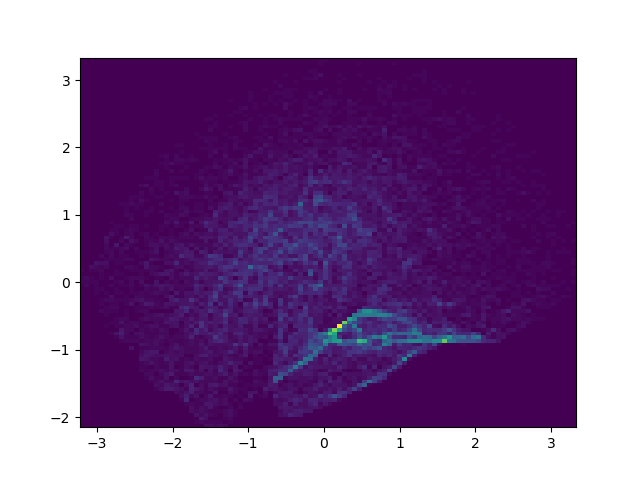

In [43]:
plt.figure()
plt.hist2d(latent_in_pc[:,0], latent_in_pc[:,1], bins=100)
plt.show()